<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Data_collection_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installing the module
%pip install unidecode

In [10]:
# Import of the training data

from google.colab import files
uploaded = files.upload()

# Import of moduls

!pip install wikidata --quiet
!pip install googletrans==4.0.0-rc1 --quiet
!pip install Levenshtein --quiet

from unidecode import unidecode
import matplotlib.pyplot as plt
import pandas as pd
from wikidata.client import Client
import requests
from googletrans import Translator
import Levenshtein

from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



Saving [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv to [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langsmith 0.3.24 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.
google-genai 1.9.0 requi

In [ ]:
# Loading the data
train_df = pd.read_csv('[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv', sep='\t')

In [3]:


def extract_entity_name(url, language = 'en'):
  """
  Function to extract the name from the wikiepedia url link
  """
  entity_id =  url.strip().split("/")[-1]
  client = Client()
  entity = client.get(entity_id,load = True)
  entity_label = entity.label.get(language)
  return entity_label



In [4]:

def translate_to_language(sentence, lang_from,lang_to):

  """
  Function that translate a text in english

  Argument :
    sentence : str, the text to translate
    lang : str, the source language

  Returns :
    translation : str, translated text
  """

  translator = Translator()
  try:
      # Translation
      translation = translator.translate(sentence, src=lang_from, dest=lang_to)
      return translation.text

  except Exception as e:
    return None




In [5]:
def extract_entity_id(url):
    return url.strip().split("/")[-1]

def get_claims(wikidata_url):
  # Extract the id of the item
    entity_id = extract_entity_id(wikidata_url)

    # Extract information of the item
    client = Client()
    item = client.get(entity_id, load=True)

    # Extract the claims of the item
    claims = item.data.get("claims", {})

    return claims


def get_country(wikidata_url):

    claims = get_claims(wikidata_url)
    client = Client()

    country_of_origin_name = None
    country_name = None
    nationality_name = None

    # Extract the statement "P495" : Country of origin
    unicode_statements = claims.get("P495", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})


            country_of_origin_id = value.get("id")
            try:
              country_of_origin_entity = client.get(country_of_origin_id, load=True)
              country_of_origin_name = country_of_origin_entity.label
            except:
              return country_of_origin_name, None, None

            return country_of_origin_name, country_name, nationality_name


    # Extract the statement "P17" : Country
    unicode_statements = claims.get("P17", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})
            country_id = value.get("id")
            try:
              country_entity = client.get(country_id, load=True)
              country_name = country_entity.label
            except:
              return country_id, None, None
            #country_entity = client.get(country_id, load=True)

            return country_of_origin_name, country_name, nationality_name


    # Extract the statement "P27" : Nationality
    unicode_statements = claims.get("P27", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})
            nationality_id = value.get("id")
            try:
              nationality_entity = client.get(nationality_id, load=True)
              nationality_name = nationality_entity.label
            except:
              return nationality_id, None, None


    return country_of_origin_name, country_name, nationality_name

In [6]:
import time



def calculate_distances(wikidata_url):

  """
  This function collects the name of the entity from the wikipedia page, translate to the choosen languages and then translate back to english
  in order to see if the back translation has been similar/ the same as the original one.

  Arguments:
    wikidata_url : str

  Return :
    dict_lang : the language, and it's associated first 1000 characters
  """

  # Initialisation of parameters, list and dictionnary

  country_of_origin = get_country(wikidata_url)

  # the lagnguages that the translation is made to, and their families

  languages = {
    'germanic': ['en', 'de', 'nl'],
    'romance': ['fr', 'es', 'pt', 'it'],
     'slavic': ['ru', 'pl', 'uk'],
     'indo-aryan': ['hi',  'mr']}

  dict_lang = {}
  dict_lang_translated = {}

  # the loop for:
  # 1. extracting the name from the wikipedia url data
  # 2. Translating to foreign language from the list languages
  # 3. Translating back to the english languge
  # 4. Calculate the levenshtein distance between the original and back translation to
  # see how close the original and round translation are
  levenshtein_distance_var = 0
  for family in languages.keys():
    for lang in languages[family]:
      name_lang= extract_entity_name(wikidata_url,'en')
      name_translated = translate_to_language(name_lang, 'en', lang)
      translated_back = translate_to_language(name_translated, lang, 'en')
      if translated_back is None:
        levenshtein_distance_var += len(name_lang)
      else:
        levenshtein_distance_var += levenshtein_distance(name_lang, translated_back)
      translitered_entity = unidecode(name_translated) if name_translated else None
      if family not in dict_lang.keys():
        dict_lang[family] = []
        dict_lang[family].append(translated_back)
        dict_lang_translated[family] = []
        dict_lang_translated[family].append(translitered_entity)
      else:
        dict_lang[family].append(translated_back)
        dict_lang_translated[family].append(translitered_entity)


  levenshtein_distance_var = levenshtein_distance_var / (sum([len(languages[key])for key in languages.keys()])  *len(name_lang))
  #print( f'the levenshtein distance is {levenshtein_distance_var}')
  return levenshtein_distance_var
  return dict_lang, dict_lang_translated


In [7]:
"""the methods defined to check the distances between the words """

# Jaccard Similitary

def jaccard_similarity(text1, text2):
  set1 = set(text1.lower().split())
  set2 = set(text2.lower().split())

  intersection = len(set1 & set2)
  union = len(set1 | set2)

  return intersection / union

# Levenstein Distance

def levenshtein_distance(text1, text2):
  return Levenshtein.distance(text1.lower(), text2.lower())

In [8]:
"""the function adding the average levenshtein distance between the original word and translation to the different languages weighted
by the inverse of the length of the word( naturally longer phrases will tend to have bigger levenshtein distance)"""
def transform_dataframe(df):
  df = df.sample(frac=1).reset_index(drop=True)
  df["nb_lang"] = df.apply(lambda x: calculate_distances(x['item']),axis=1)

  return df


In [25]:
"""the execution of the translation limited only to random 50 samples from each group due to the high, cost of the
wikipedia api quering"""
exclusive_df = transform_dataframe(train_df[train_df['label'] == 'cultural exclusive'].head(50))
exclusive_df['nb_lang'].sum()

np.float64(7.4116702160371215)

In [26]:
"""the execution of the translation limited only to random 50 samples from each group due to the high, cost of the
wikipedia api quering"""
representative_df = transform_dataframe(train_df[train_df['label'] == 'cultural representative'].head(50))
representative_df['nb_lang'].sum()

np.float64(6.608248591828448)

In [27]:
"""the execution of the translation limited only to random 50 samples from each group due to the high, cost of the
wikipedia api quering"""
agnostic_df = transform_dataframe(train_df[train_df['label'] == 'cultural agnostic'].head(50))
agnostic_df['nb_lang'].sum()

np.float64(12.568282142259402)

In [28]:
"""exploring the head of the dataframe"""
exclusive_df.head(50)

,item,name,description,type,category,subcategory,label,nb_lang
0,http://www.wikidata.org/entity/Q1503,Manuel L. Quezon,President of the Philippines from 1935 to 1944,entity,politics,politician,cultural exclusive,0.057292
1,http://www.wikidata.org/entity/Q12499,Patrick Janssens,Flemish politician; former mayor of Antwerp,entity,politics,politician,cultural exclusive,0.078125
2,http://www.wikidata.org/entity/Q31754863,Intendant of Montevideo,head of government of Montevideo,concept,politics,politician,cultural exclusive,0.358696
3,http://www.wikidata.org/entity/Q5208,Huang Xianfan,"Chinese historian, ethnologist and educator (1...",entity,politics,politician,cultural exclusive,0.064103
4,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,cultural exclusive,0.067708
5,http://www.wikidata.org/entity/Q109678442,Leader of the National Party of Australia in N...,NSW party leader,entity,politics,politician,cultural exclusive,0.251389
6,http://www.wikidata.org/entity/Q1440,Didius Julianus,emperor of ancient Rome (193 CE),entity,politics,politician,cultural exclusive,0.038889
7,http://www.wikidata.org/entity/Q579677,President of Ukraine,head of state of Ukraine,concept,politics,politician,cultural exclusive,0.145833
8,http://www.wikidata.org/entity/Q133278742,Mary Theresa King-Myers,first female municipal councillor in rural Canada,entity,politics,politician,cultural exclusive,0.050725
9,http://www.wikidata.org/entity/Q3382119,sub-prefect,senior civil servant in France,concept,politics,politician,cultural exclusive,0.378788


In [30]:
representative_df.head(50)

,item,name,description,type,category,subcategory,label,nb_lang
0,http://www.wikidata.org/entity/Q5327,Adolf Butenandt,German biochemist (1903-1995),entity,politics,politician,cultural representative,0.055556
1,http://www.wikidata.org/entity/Q373085,chancellor,executive position in a government,concept,politics,politician,cultural representative,0.308333
2,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative,0.000000
3,http://www.wikidata.org/entity/Q1480,Corazon Aquino,President of the Philippines from 1986 to 1992,entity,politics,politician,cultural representative,0.244048
4,http://www.wikidata.org/entity/Q1446,Caracalla,Roman emperor from 198 to 217,entity,politics,politician,cultural representative,0.074074
5,http://www.wikidata.org/entity/Q2578792,Look East policy,India's foreign policy to deal with South-East...,entity,politics,policy,cultural representative,0.390625
6,http://www.wikidata.org/entity/Q510195,blasphemy law,law prohibiting blasphemy,entity,politics,law,cultural representative,0.346154
7,http://www.wikidata.org/entity/Q61812192,Islamic family jurisprudence,legal traditions regarding Muslim Family law,concept,politics,law,cultural representative,0.255952
8,http://www.wikidata.org/entity/Q1625,Sigfrid Edström,Swedish industrialist and International Olympi...,entity,politics,politician,cultural representative,0.061111
9,http://www.wikidata.org/entity/Q9513,A. P. J. Abdul Kalam,Indian scientist and statesman (1931–2015),entity,politics,politician,cultural representative,0.041667


In [31]:
agnostic_df.head(50)

,item,name,description,type,category,subcategory,label,nb_lang
0,http://www.wikidata.org/entity/Q5520196,gaming control board,government agency,concept,politics,government agency,cultural agnostic,0.258333
1,http://www.wikidata.org/entity/Q3754526,government administration,government or political organization,concept,politics,government agency,cultural agnostic,0.070000
2,http://www.wikidata.org/entity/Q4175034,legislator,member of a legislature,concept,politics,politician,cultural agnostic,0.483333
3,http://www.wikidata.org/entity/Q5260216,department of corrections,"a type of government agency, found in many jur...",concept,politics,government agency,cultural agnostic,0.503333
4,http://www.wikidata.org/entity/Q836971,party secretary,senior official within a political party with ...,concept,politics,politician,cultural agnostic,0.000000
5,http://www.wikidata.org/entity/Q7834723,transnational political party,Political party with members in multiple count...,concept,politics,political party,cultural agnostic,0.020115
6,http://www.wikidata.org/entity/Q15686806,senator,"member of a senate, usually the upper house of...",concept,politics,politician,cultural agnostic,0.440476
7,http://www.wikidata.org/entity/Q19772737,political candidate,candidate in an election for political office,concept,politics,politician,cultural agnostic,0.083333
8,http://www.wikidata.org/entity/Q5260434,department of parks and recreation,governmental organization that overseas public...,concept,politics,government agency,cultural agnostic,0.399510
9,http://www.wikidata.org/entity/Q7889581,ethnic party,political party that represents the interests ...,concept,politics,political party,cultural agnostic,0.090278


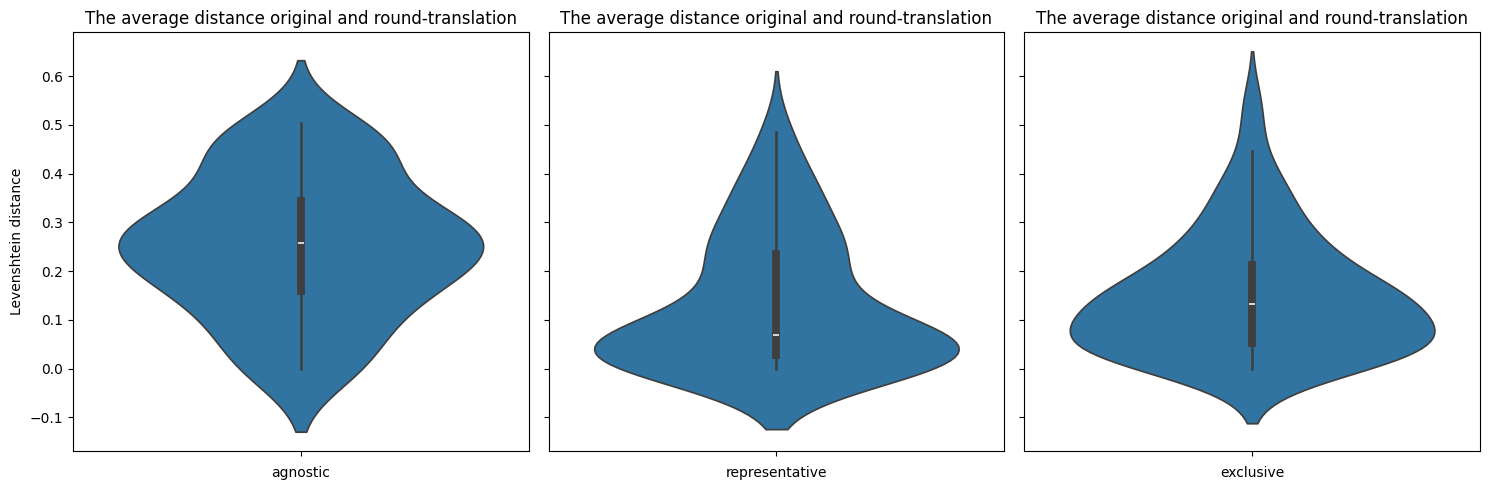

In [44]:
"""plotting the distirbution of the average translation distance for each group"""
# low, high = np.percentile(df_lang_dropped['nb_lang'], [2, 98])
# df_lang_dropped['nb_lang_clipped'] = df_lang_dropped['nb_lang'].clip(lower=low, upper=high)

# Create boxplot
from matplotlib import pyplot as plt
import seaborn as sns

categories = [agnostic_df, representative_df, exclusive_df]
the_names = ['agnostic', 'representative', 'exclusive']
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, label in enumerate(categories):
  ax = axes[i]
  #plt.figure(figsize=(10, 6))
  sns.violinplot(data=label, y='nb_lang', fill=True, ax=ax)
  ax.set_title('The average distance original and round-translation')
  ax.set_xlabel(the_names[i])
  ax.set_ylabel('Levenshtein distance')
  plt.tight_layout()
plt.show()




In [48]:
representative_df['len_column'] = representative_df['name'].str.len()
agnostic_df['len_column'] =  agnostic_df['name'].str.len()
exclusive_df['len_column'] = exclusive_df['name'].str.len()


In [46]:
representative_df.head()

,item,name,description,type,category,subcategory,label,nb_lang
0,http://www.wikidata.org/entity/Q5327,Adolf Butenandt,German biochemist (1903-1995),entity,politics,politician,cultural representative,0.055556
1,http://www.wikidata.org/entity/Q373085,chancellor,executive position in a government,concept,politics,politician,cultural representative,0.308333
2,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative,0.000000
3,http://www.wikidata.org/entity/Q1480,Corazon Aquino,President of the Philippines from 1986 to 1992,entity,politics,politician,cultural representative,0.244048
4,http://www.wikidata.org/entity/Q1446,Caracalla,Roman emperor from 198 to 217,entity,politics,politician,cultural representative,0.074074


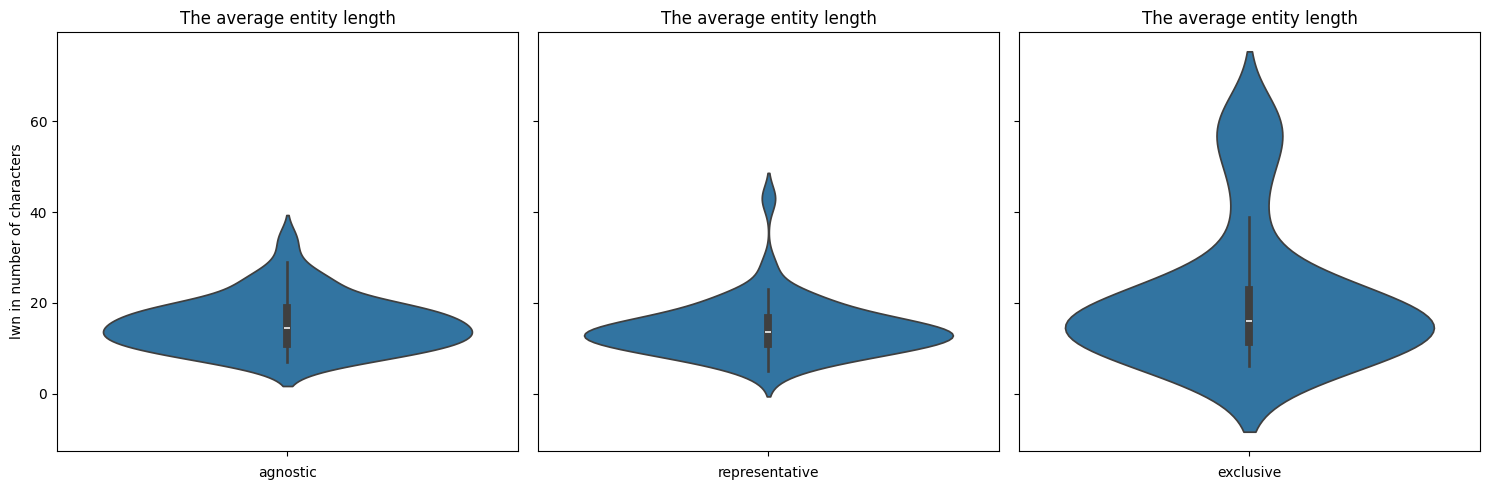

In [49]:
"""visualizing the distiribution of the length of the entities to see if this is maybe correlated to the lveneshtein distance
and leads to false conclusions"""
categories = [agnostic_df, representative_df, exclusive_df]
the_names = ['agnostic', 'representative', 'exclusive']
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, label in enumerate(categories):
  ax = axes[i]
  #plt.figure(figsize=(10, 6))
  sns.violinplot(data=label, y='len_column', fill=True, ax=ax)
  ax.set_title('The average entity length')
  ax.set_xlabel(the_names[i])
  ax.set_ylabel('lwn in number of characters')
  #plt.xticks(rotation=45)
  plt.tight_layout()
plt.show()

## Fast-text based similarity
### Todo, but it requires downloading some kind of embeddings like fasttext, which would be 10 GB, so later prolly


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject